## General Imports
All numerical calculations are done with numpy.
Futher functionality for plotting is hidden in utils.py.
Finally, to calculate the tube shape, a module library called `pyctr` is used, which was developed by the authors and can be found [here](https://github.com/IRP-TU-BS/pyctr).

In [1]:
import numpy as np

In [2]:
import pyvista as pv
pv.set_jupyter_backend('static') # for inteactive view set to "trame"

## Local Imports

In [3]:
from utils import *

## CTR Imports

In [4]:
from pyctr.cosserat_rod import *

## Build Model Tubes
The following cell detemines the curature of the tubes or a 2-tube CTR. Futhermore, the sample density along the tubes body can be defined by the step_size.
Finally, the tube parameters are set.

In [5]:
ROD1_CURVATURE = 8.0
ROD2_CURVATURE = 2.0

STEP_SIZE = 0.001

In [6]:
ROD1_PARAMS = {
    "kappa": ROD1_CURVATURE,
    "L": 150.0 * 1e-3,
    "straight_length": 0.05,
}
ROD2_PARAMS = {
    "kappa": ROD2_CURVATURE,
    "r_inner": 1.5 * 1e-3,
    "r_outer": 2.5 * 1e-3,
    "L": 90.0 * 1e-3,
    "straight_length": 80.0 * 1e-3,
}

### Create tubes 
The following section is creatig the tube and CTR objects eeded for calulating the robots shape.

#### Curved tubes
First a set of curved tubes is created and with those tubes, a CTR is generated.

In [7]:
curved_rod1 = create_rod(ROD1_PARAMS)
curved_rod2 = create_rod(ROD2_PARAMS)

In [8]:
# Please be not confused. The wrapper is used to decorate the tubes with additional functionality such as push_end, which enables the application of a force to the tip of the tubes.
curved_rod1_ctr = create_ctr_wrapper([curved_rod1])
curved_rod2_ctr = create_ctr_wrapper([curved_rod2])

In [9]:
ctr = create_ctr_wrapper([curved_rod1, curved_rod2])

#### Straight
Additionally, straight tubes with the same properties are created.

In [10]:
ROD1_PARAMS["kappa"] = 0
ROD2_PARAMS["kappa"] = 0

In [11]:
straight_rod1 = create_rod(ROD1_PARAMS)
straight_rod2 = create_rod(ROD2_PARAMS)

In [12]:
straight_rod1_ctr = create_ctr_wrapper([straight_rod1])
straight_rod2_ctr = create_ctr_wrapper([straight_rod2])

In [13]:
straight_ctr = create_ctr_wrapper([straight_rod1, straight_rod2])

### Create instances geometry of the robots
For plotting the shape of the tubes, we calculate the tubes shape when no force is applied to there tips.

In [14]:
from ctr_diffeomorphism import create_extended_copy_of_tube

In [15]:
crod1_pos, crod1_ori = curved_rod1_ctr.push_end(np.zeros(6), STEP_SIZE)[0:2]
crod2_pos, crod2_ori = curved_rod2_ctr.push_end(np.zeros(6), STEP_SIZE)[0:2]

In [16]:
srod1_pos = straight_rod1_ctr.push_end(np.zeros(6), STEP_SIZE)[0]
srod2_pos = straight_rod2_ctr.push_end(np.zeros(6), STEP_SIZE)[0]

We use a special function to extend the second tube, which is smaller than the first, by a straight section at its end until the extend tube has the same length as the first one. 

In [17]:
crod2_ext_pos = create_extended_copy_of_tube(crod2_pos, crod2_ori, crod1_pos.shape[0], STEP_SIZE)

### Find the diffeomorphism
For both tubes we find the paramters for a diffeomorphic mapping between straight and curved tube intances.

In [18]:
from ctr_diffeomorphism import *

In [19]:
# First diifeo step
p1, c1, v1 = find_diffeo_map(srod1_pos, crod1_pos, K=25, beta=0.4)
p1 = p1.reshape(-1, 1)
c1 = np.array(c1).reshape(-1, 1)

In [20]:
# Second diffeo step
p2, c2, v2 = find_diffeo_map(srod2_pos, crod2_pos, K=25, beta=0.4)
p2 = p2.reshape(-1, 1)
c2 = np.array(c2).reshape(-1, 1)

Additionally, we get the tubes material properties.

In [21]:
E1 = curved_rod1.params["E"]
I1 = curved_rod1.params["I"]
EI1 = E1*I1 
L1 = curved_rod1.params["L"]
E2 = curved_rod2.params["E"]
I2 = curved_rod2.params["I"]
EI2 = E2*I2
L2 = curved_rod2.params["L"]

## Diffeomorphism for whole robot
In the following cells we calculate the diffeomorphism for the whole robot.
We show how to apply the forward and the inverse diffeomorphism.

You can change the configuration in the next cell.

In [22]:
# Change the rotation and translation of the tubes
alphas = [-np.pi,np.pi/2]
betas = [0.2,0.4]

As described in the paper, all tubes that are smaller than the longest one need to be extended to have influence of the succeeding diffeomorphic mappings

In [23]:
p2, c2, v2 = find_diffeo_map(srod1_pos, crod2_ext_pos, K=25, beta=0.4)
p2 = p2.reshape(-1, 1)
c2 = np.array(c2).reshape(-1, 1)

The next cells generate the positions data for the curved and straight tube

In [24]:
straight_ctr.rotate([0,0])
straight_ctr.translate([0,0])

sctr_pos = straight_ctr.push_end(np.zeros(6),STEP_SIZE)[0]

In [25]:
ctr.rotate([0, 0])
ctr.translate([0,0])
straight_ctr.rotate([0,0])
straight_ctr.translate([0,0])

ctr.rotate(alphas)
ctr.translate(betas)
cctr_pos = ctr.push_end(np.zeros(6), STEP_SIZE)[0]

Let us plot the straight tube without changes in the configuration and your chosen configuration for the curved tube robot. 

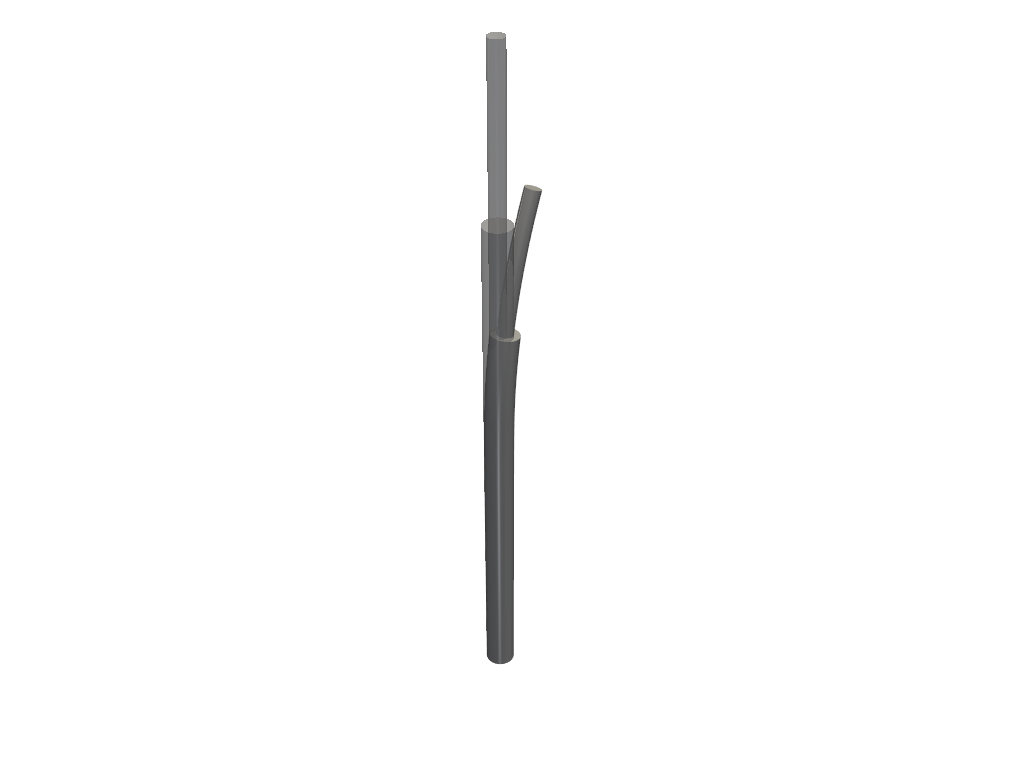

In [26]:
indices, ds = get_plot_len_and_size(
    straight_ctr,
    sctr_pos.shape[0],
     betas
)
curved_indices, curved_ds = get_plot_len_and_size(
    ctr,
    cctr_pos.shape[0],
    betas
)

plotter = pv.Plotter()

plotter = simple_plot_tubes_pyvista(plotter, sctr_pos, indices, ds, "straight tubes", 0.5)
plotter = simple_plot_tubes_pyvista(plotter, cctr_pos, curved_indices, curved_ds, "curved_tubes", 1)
#plotter.add_points(cctr_pos, color='red', point_size=20, render_points_as_spheres=True)

# Set the camera position
plotter.camera_position = "iso"  # Isometric view

# Display the plot
plotter.show()

#### Apply the forward diffeomorphismus

In [27]:
diffeo_cpos = do_forward_diffeo(sctr_pos, alphas, betas, np.hstack([p1,p2]),  np.hstack([c1,c2]),  np.hstack([v1,v2]), [EI1, EI2], [L1, L2])

In [28]:
# This functions generate information solely for plotting purposes

indices, ds = get_plot_len_and_size(
    ctr,
    sctr_pos.shape[0],
    betas
)

diffeo_indices, diffeo_ds = get_plot_len_and_size(
    ctr,
    diffeo_cpos.shape[0],
    betas
)

curved_indices, curved_ds = get_plot_len_and_size(
    ctr,
    cctr_pos.shape[0],
    betas
)

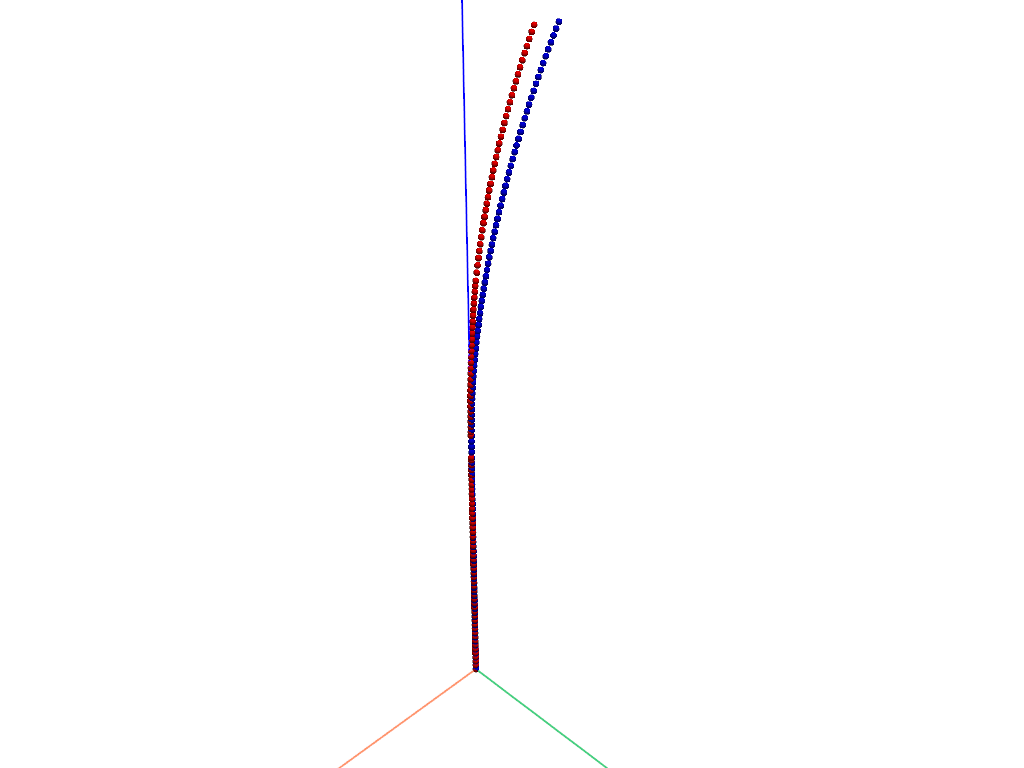

In [29]:
plotter = pv.Plotter()

plotter.add_points(cctr_pos, color='blue', point_size=7, render_points_as_spheres=True)

plotter.add_points(diffeo_cpos, color='red', point_size=7, render_points_as_spheres=True)

# Set the camera position
plotter.camera_position = "iso"  # Isometric view
_ = plotter.add_axes_at_origin()
# Display the plot
plotter.show()

#### Apply the inverse diffeomorphismus

In [30]:
diffeo_cpos = do_inverse_diffeo(cctr_pos, alphas, betas, np.hstack([p1,p2]),  np.hstack([c1,c2]),  np.hstack([v1,v2]), [EI1, EI2], [L1, L2])


In [31]:
indices, ds = get_plot_len_and_size(
    ctr,
    sctr_pos.shape[0],
    betas
)

diffeo_indices, diffeo_ds = get_plot_len_and_size(
    ctr,
    diffeo_cpos.shape[0],
    betas
)

curved_indices, curved_ds = get_plot_len_and_size(
    ctr,
    cctr_pos.shape[0],
    betas
)

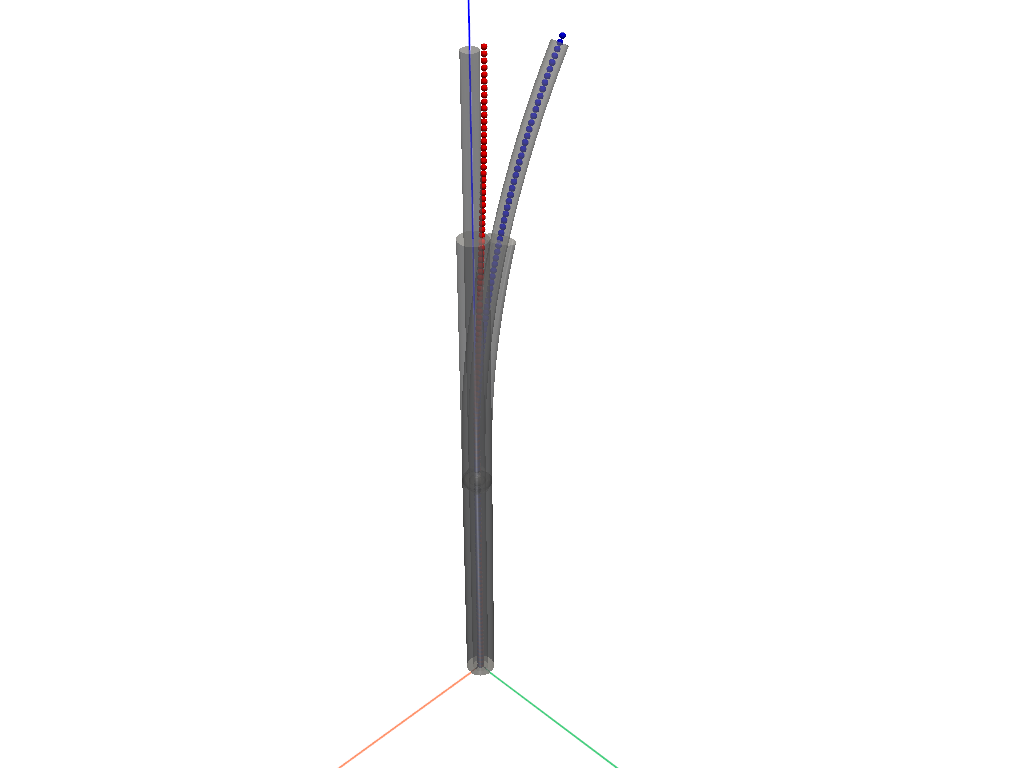

In [33]:
plotter = pv.Plotter()
plotter = simple_plot_tubes_pyvista(plotter, sctr_pos, indices, ds, "straight tubes", 0.5)
plotter = simple_plot_tubes_pyvista(plotter, cctr_pos, indices, ds, "curved tubes", 0.5)

plotter.add_points(cctr_pos, color='blue', point_size=7, render_points_as_spheres=True)

plotter.add_points(diffeo_cpos, color='red', point_size=7, render_points_as_spheres=True)

# Set the camera position
plotter.camera_position = "iso"  # Isometric view
_ = plotter.add_axes_at_origin()
# Display the plot
plotter.show()

# 